In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan

In [2]:
electoral_votes = {
    'Alabama': 9,
    'Alaska': 3,
    'Arizona': 11,
    'Arkansas': 6,
    'Colorado': 9,
}

survey_results = {
    'Alabama': np.array([[611, 397, 0, 0], [799, 528, 0, 0], [793, 403, 0, 0], [288, 264, 0, 0], [353, 219, 0, 0], [997, 554, 0, 0], [312, 232, 0, 0], [409, 227, 0, 0], [319, 234, 0, 0]]),
    'Alaska': np.array([[348, 320, 0, 0], [298, 253, 0, 0], [283, 277, 0, 0], [269, 198, 0, 0], [227, 177, 0, 0], [442, 389, 0, 0], [519, 486, 0, 0], [325, 318, 0, 0], [84, 74, 0, 0]]),
    'Arizona': np.array([[522, 478, 22, 0], [313, 356, 7, 7], [291, 304, 0, 0], [270, 288, 0, 0], [236, 264, 16, 0], [180, 184, 0, 0], [133, 151, 0, 0], [269, 321, 20, 0], [230, 250, 5, 0], [3337, 3621, 0, 0], [360, 392, 0, 0], [235, 235, 0, 0], [364, 396, 8, 0], [383, 409, 9, 9], [221, 216, 0, 0], [113, 128, 0, 0], [284, 278, 0, 0], [168, 212, 0, 0], [258, 270, 0, 0], [260, 266, 0, 0], [359, 402, 9, 0], [185, 202, 17, 0], [261, 320, 26, 0], [519, 584, 0, 0], [328, 342, 0, 0], [487, 520, 0, 0], [252, 312, 0, 0], [752, 768, 0, 0], [414, 441, 0, 0], [212, 230, 0, 0], [357, 398, 0, 8], [309, 378, 23, 0], [3357, 3034, 0, 0], [396, 490, 0, 0], [162, 169, 0, 0], [325, 402, 9, 9], [445, 426, 0, 0], [311, 350, 0, 0], [188, 193, 0, 0], [466, 456, 30, 0], [271, 295, 0, 0], [204, 192, 0, 0], [522, 547, 24, 12], [2547, 2348, 0, 0], [164, 172, 0, 0], [381, 445, 0, 0], [393, 428, 0, 0], [326, 395, 17, 9], [372, 413, 0, 0], [432, 470, 0, 0], [315, 343, 0, 0], [155, 176, 0, 0], [500, 500, 0, 0], [264, 294, 0, 0], [1230, 1088, 0, 0], [270, 282, 0, 0], [137, 159, 0, 0], [258, 237, 0, 0], [337, 372, 17, 9], [266, 312, 0, 0], [616, 670, 0, 0], [88, 90, 0, 0], [421, 461, 0, 0], [148, 145, 0, 0], [368, 353, 0, 0], [180, 188, 0, 0], [388, 426, 0, 0], [258, 300, 0, 0], [230, 235, 0, 0], [258, 312, 0, 0]]),
    'Arkansas': np.array([[478, 293, 0, 0], [462, 220, 0, 0], [493, 239, 0, 0], [209, 135, 0, 0], [408, 391, 0, 0]]),
    'Colorado': np.array([[408, 510, 0, 0], [1114, 1549, 0, 0], [283, 322, 0, 0], [320, 400, 0, 0], [312, 400, 32, 8], [978, 1359, 0, 0], [262, 325, 0, 0], [252, 306, 0, 0], [246, 307, 0, 0], [246, 306, 0, 0], [240, 312, 0, 0], [935, 1355, 0, 0], [240, 320, 0, 0], [246, 306, 0, 0], [365, 481, 0, 0], [328, 470, 0, 0], [457, 620, 0, 0], [240, 286, 0, 0], [280, 371, 0, 0], [216, 330, 0, 0], [133, 201, 0, 0]]),
}

for key, value in survey_results.items():
    survey_results[key] = np.concatenate((value[:,:2], value[:,2:3] + value[:,3:4]), axis=1)

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 5 states with 38 electoral college votes


In [3]:
stan_code = '''
data {
  int<lower=1> C; // number of categories
  int<lower=1> n; //number of surveys
  int k[n, C]; //vote count for each of survey data
  real mu;
  real <lower=0>sigma;
}

parameters {
  vector[C] alpha; //probability vector for posterior
  simplex[C] p[n]; //creating an array p with n vectors of size C
}

model {
  alpha ~ cauchy(mu,sigma); //prior over alpha
  for (i in 1:n){
    p[i] ~ dirichlet(alpha);
    k[i] ~ multinomial(p[i]);
  }
}
'''



In [4]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7ebe25231a651d002bbe952367b5e83 NOW.


In [5]:
results_posterior = {}
for state in survey_results.keys():
  stan_data = {
      'C': survey_results[state].shape[1],
      'n': survey_results[state].shape[0],
      'k': survey_results[state],
      'mu':0,
      'sigma':1
  }
  results_posterior[state] = stan_model.sampling(data=stan_data)



Alabama


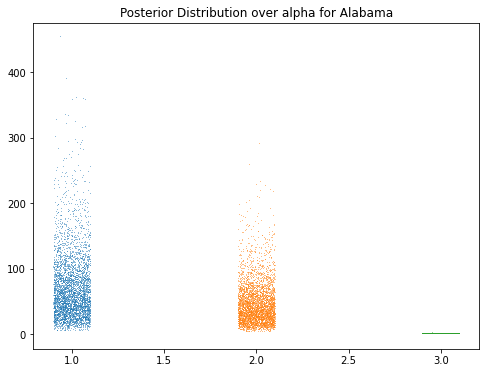

Alaska


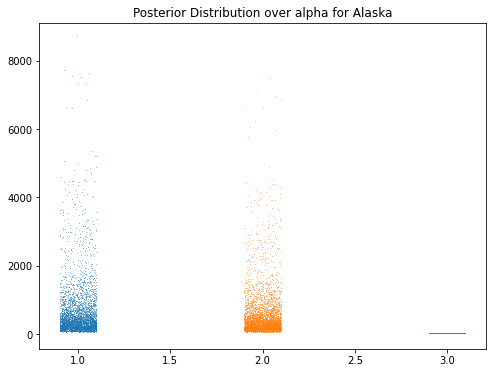

Arizona


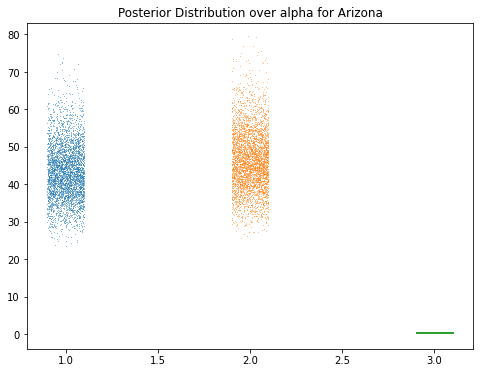

Arkansas


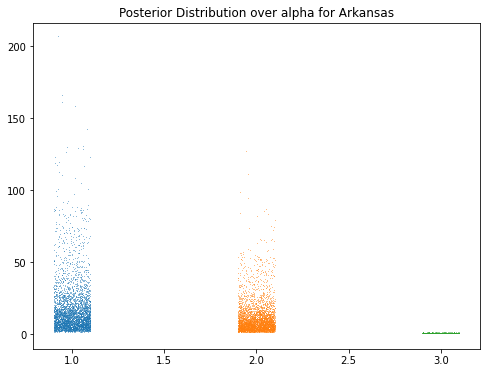

Colorado


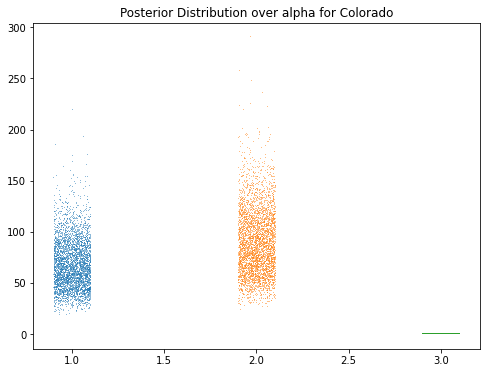

In [6]:
#Visualization of Survey Results
for state in survey_results.keys():
  print(state)
  res = results_posterior[state].extract()
  plt.figure(figsize=(8,6))
  for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2,
                             size=res['alpha'].shape[0],
                             ),
             res['alpha'][:,i], ',', alpha=0.5)
    plt.title('Posterior Distribution over alpha for %s'%(state))
  plt.show()


# Simulation

In [10]:
#prediction of who will win the states
ct = 1 
state_leader = {}

for state in results_posterior.keys():
  samples = results_posterior[state].extract()
  prediction = np.empty(samples['alpha'].shape)
  
  for i in range(samples['alpha'].shape[0]):
    new_p = [0,0,0]

    for _ in range(ct):
      sample_p = sts.dirichlet(samples['alpha'][i]).rvs()

      for j in range(3):
        new_p[j] += sample_p[0][j]

    new_p = [k/ct for k in new_p]
    prediction[i] = new_p

  winners = np.argmax(prediction, axis=1)
  cts = np.bincount(winners)
  if len(cts) == 2:
    probability_state_win = [cts[0]/sum(qts), cts[1]/sum(cts), 0]
    
  else:
    probability_state_win= [cts[0]/sum(cts), cts[1]/sum(cts), cts[2]/sum(cts)]
  state_leader[state] = probability_state_win


In [12]:
# Simulating the election to find the winner
total_sim = 100000
candidate_wins = [0,0,0]

for i in range(total_sim): 
  total_electoral_votes = [0,0,0]

  for state in state_leader.keys():
    random_number = np.random.random()

    if random_number < state_leader[state][0]: 
      total_electoral_votes[0] += electoral_votes[state]

    elif random_number > (1-state_leader[state][2]): 
      total_electoral_votes[0] += electoral_votes[state]

    else: 
      total_electoral_votes[1] += electoral_votes[state]
  
  candidate_wins[np.argmax(total_electoral_votes)] += 1



print('Probability Trump wins: %.2f'%(candidate_wins[0]*100/total_sim))
print('Probability Biden wins: %.2f'%(candidate_wins[1]*100/total_sim))

Probability Trump wins: 40.19
Probability Biden wins: 59.81
